# Model to predict galaxy distribution features from halo properties

In [103]:
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy import stats
from scipy.stats import poisson

### Input features will be halo mass, halo redshift, virial velocity, velocity dispersion, total luminosity (based on absolute R magnitudes). 

### Labels will be number of galaxies in the halo and distribution of distance to the center for galaxies in the group represented by mean and standard deviation.

### Bring in data and compute necessary features.  We have number of galaxies, halo mass, virial velocity, and halo redshift.  We need to determine the max radius, velocity dispersion, total luminosity and radius distribution (mean, sd) for each halo.

In [2]:
#Define a function to bring in MICECATv2 fits file, pre-process data, sample a specified number of halos and return a halo dataframe.
def preprocess(fits_file, num):
    #Read in galaxy/halo data from fits file, convert to dataframe
    table = Table.read(fits_file)
    data = table.to_pandas()
    
    #Calculate euclidean distance between galaxy position and position of the halo center.  Set as a new column.
    data['dist_to_ctr'] = ((data['xgal']-data['xhalo'])**2 + (data['ygal']-data['yhalo'])**2+ (data['zgal']-data['zhalo'])**2)**.5
    
    #Use the formula for evolution correction given on the MICE website: magnitude_evolved = magnitude_catalog - 0.8 * (atan(1.5 * z_cgal) - 0.1489)
    data['mag_corr'] = data['mr_gal'] - 0.8 * (np.arctan(1.5 * data['z_cgal']) - 0.1489)
    
    #Add a column for luminosity of each galaxy (10^-0.4*M)
    data['luminosity']=10**(-0.4*data['mag_corr'])
    
    #Determine the mean radial velocity for each halo so we can calculate the velocity dispersion for each halo.
    data=data.merge(data.groupby('unique_halo_id')['vcgal'].mean().reset_index(), on='unique_halo_id', how='outer')
    data=data.rename(columns={'vcgal_x':'vcgal', 'vcgal_y':'vcgal_mean'})
    data['v_var']=(data['vcgal']-data['vcgal_mean'])**2
    
    #Make a new data frame for halos using groupby.  This will eventually be the output.
    #Group the table by halo_id and count the number of galaxies assigned to each halo - compare to the 'nsats' property listed.
    halo_data = data.groupby('unique_halo_id')['nsats'].value_counts().to_frame()
    halo_data.columns=['count']
    halo_data=halo_data.reset_index()
    
    #Add a column to halo data for 'Ngal'.
    halo_data['Ngal']=halo_data['count']
    
    #Group the galaxy dataframe by halo id and use groupby with mean() to add columns for halo mass, virial velocity, mean radius, mean velocity, and mean velocity variation to the halo dataframe.
    halo_data=halo_data.merge(data.groupby('unique_halo_id')['lmhalo', 'v_vir', 'dist_to_ctr', 'vcgal_mean', 'v_var'].mean().reset_index(), on='unique_halo_id', how='outer')
    halo_data=halo_data.rename(columns={'lmhalo':'halo_mass', 'dist_to_ctr':'radius_mean'})
    
    # Same as above but use max() to add a column for maximum radius.
    halo_data=halo_data.merge(data.groupby('unique_halo_id')['dist_to_ctr'].max().reset_index(), on='unique_halo_id', how='outer')
    halo_data=halo_data.rename(columns={'dist_to_ctr':'radius_max'})
    
    # Same as above but use sum() to add a column for total luminosity.
    halo_data=halo_data.merge(data.groupby('unique_halo_id')['luminosity'].sum().reset_index(), on='unique_halo_id', how='outer')

    # Convert a total luminosity to a total absolute magnitude.
    halo_data['halo_mag']=-2.5*np.log10(halo_data['luminosity'])
    
    # Same as above but use std() to add a column for standard deviation of radius.
    halo_data=halo_data.merge(data.groupby('unique_halo_id')['dist_to_ctr'].std().reset_index(), on='unique_halo_id', how='outer')
    halo_data=halo_data.rename(columns={'dist_to_ctr':'radius_std'})
    
    # Use the true redshift and absolute magnitude of the central galaxy for each halo as the halo redshift and central gal magnitude.
    halo_data=halo_data.merge(data[data['flag_central']==0][['unique_halo_id','z_cgal', 'mag_corr']], on='unique_halo_id', how='outer')
    halo_data=halo_data.rename(columns={'z_cgal':'z_halo', 'mag_corr':'mag_central'})
    
    #Find the next brightest galaxy magnitude and compute the gap between the central galaxy and next brightest.
    halo_data=halo_data.merge(data[data['flag_central']==1].groupby('unique_halo_id')['mag_corr'].min().reset_index(), on='unique_halo_id', how='outer')
    halo_data['mag_gap']=halo_data['mag_corr']-halo_data['mag_central']
    halo_data.loc[halo_data.Ngal==1, 'mag_gap']=0
    
    #Compute velocity dispersion for halos with more than one galaxy.  If Ngal==1, set v_disp=0.
    halo_data['v_disp'] = np.where(halo_data['Ngal']==1, 0, np.sqrt(halo_data['v_var'])/(1+halo_data['z_halo']))
    
    # For the halos with one galaxy, set the standard deviation of the radius to zero.
    halo_data.loc[halo_data.radius_mean==0,'radius_std']=0
    
    # Drop unnecessary columns.
    halo_data=halo_data.drop(['nsats','count','luminosity', 'vcgal_mean', 'v_var', 'mag_corr'], axis=1)
    
    #Print number of halos in file.
    print('Choosing ', num, ' halos out of ', len(halo_data), 'halos in file.')
   
    if num < len(halo_data):
        rep=False
    else:
        rep=True
        
    return halo_data.sample(num, replace=rep)

In [3]:
#Read in galaxy/halo data.
data_set=preprocess('5607.fits', 100000)

Choosing  100000  halos out of  142129 halos in file.


In [4]:
data_set=data_set.append(preprocess('5608.fits', 100000))

Choosing  100000  halos out of  193608 halos in file.


In [5]:
data_set=data_set.append(preprocess('5609.fits', 100000))

Choosing  100000  halos out of  126073 halos in file.


In [6]:
data_set=data_set.append(preprocess('5610.fits', 100000))

Choosing  100000  halos out of  3737756 halos in file.


In [7]:
data_set=data_set.append(preprocess('5611.fits', 50000))

Choosing  50000  halos out of  731289 halos in file.


In [8]:
data_set=data_set.append(preprocess('5612.fits', 100000))

Choosing  100000  halos out of  493076 halos in file.


In [9]:
data_set=data_set.dropna()
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549575 entries, 59704 to 438578
Data columns (total 12 columns):
unique_halo_id    549575 non-null int64
Ngal              549575 non-null int64
halo_mass         549575 non-null float32
v_vir             549575 non-null float32
radius_mean       549575 non-null float32
radius_max        549575 non-null float32
halo_mag          549575 non-null float64
radius_std        549575 non-null float32
z_halo            549575 non-null float64
mag_central       549575 non-null float64
mag_gap           549575 non-null float64
v_disp            549575 non-null float64
dtypes: float32(5), float64(5), int64(2)
memory usage: 44.0 MB


### Make a test set that is representative (not over or under sampled)

In [152]:
# Import a file with no Ngal restrictions and sample from it.  Drop rows with NA values.
test_set=preprocess('5614.fits', 50000)
test_set=test_set.dropna()

Choosing  50000  halos out of  4491970 halos in file.


In [153]:
#Print which halos from test set match halos from data set.
both = test_set.merge(data_set, on='unique_halo_id', how='inner')['unique_halo_id'].unique()

In [154]:
data_set = data_set[~data_set['unique_halo_id'].isin(both.tolist())]

Correlation:               mag_central  halo_mass
mag_central     1.000000  -0.868067
halo_mass      -0.868067   1.000000


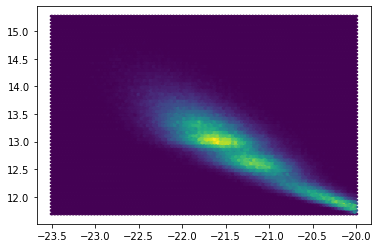

In [261]:
plt.hexbin(data_set[data_set['mag_central']<-20]['mag_central'],data_set[data_set['mag_central']<=-20]['halo_mass'])
print("Correlation: ", data_set[data_set['mag_central']<-20][['mag_central', 'halo_mass']].corr())

# Random Forest Model - for comparison

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## RF Model to predict mean radius

In [155]:
#Make features and label arrays
features = ['halo_mass','z_halo', 'v_disp', 'v_vir']
label = ['radius_mean']

X = data_set[features].values
y = np.ravel(data_set[label].values)

In [156]:
rtest_X = test_set[features].values
rtest_y = np.ravel(test_set[label].values)

In [157]:
#Split data into test and train sets
rtrain_X, rval_X, rtrain_y, rval_y =  train_test_split(X,y)

In [158]:
#Train Random Forest Model
rhalo_RF_model = RandomForestRegressor(n_estimators=100, max_depth=35, verbose=True)
rhalo_RF_model.fit(rtrain_X, rtrain_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.8min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=True, warm_start=False)

In [159]:
rtest_preds = rhalo_RF_model.predict(rtest_X)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished


In [160]:
# Print root mean squared error
from sklearn.metrics import mean_squared_error
print('RMSE for mean radius: ', np.sqrt(mean_squared_error(rtest_y, rtest_preds)))
print('Training Set size: ', len(rtrain_y))
print('Test Set size: ', len(rtest_preds))

RMSE for mean radius:  0.014769594477502522
Training Set size:  412060
Test Set size:  49981


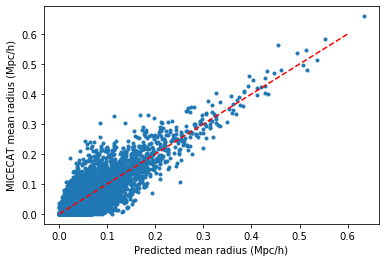

In [161]:
#Plot actual mean radius vs. predicted mean radius.
plt.plot(rtest_preds,rtest_y, '.')
plt.ylabel('MICECAT mean radius (Mpc/h)')
plt.xlabel('Predicted mean radius (Mpc/h)')
#plt.ylim(bottom=-.1)
line_x, line_y = np.arange(0,0.7,0.1), np.arange(0,0.7,0.1)
plt.plot(line_x,line_y,'r--')
plt.show()

Text(0.5, 1.0, 'Mean radius distributions for MICECAT and model prediction')

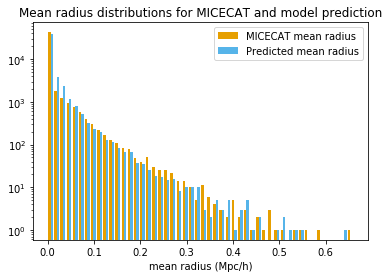

In [162]:
#Plot distributions of true mean radius and predicted mean radius

x1 = list(rtest_y)
x2 = list(rtest_preds.flatten())
# Assign colors for each group and the names
colors = ['#E69F00', '#56B4E9']
names = ['MICECAT mean radius', 'Predicted mean radius']

plt.hist([x1,x2], bins = 50, color=colors, label=names)
plt.yscale('log')

# Plot formatting
plt.legend()
plt.xlabel('mean radius (Mpc/h)')
#plt.ylabel('Normalized data')
plt.title('Mean radius distributions for MICECAT and model prediction')

In [163]:
#Feature selection
rfeature_importances = pd.DataFrame(rhalo_RF_model.feature_importances_,
                                   index = data_set[features].columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(rfeature_importances)



           importance
halo_mass    0.790586
v_vir        0.155543
v_disp       0.028806
z_halo       0.025065


/Users/amandawhaley/anaconda3/envs/MLGalaxyClusters/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/amandawhaley/anaconda3/envs/MLGalaxyClusters/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'fractional error')

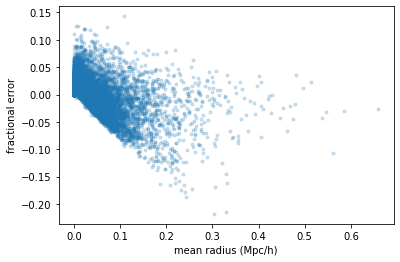

In [165]:
#Determine residuals and error.
rresiduals=rtest_preds-rtest_y
rerrors=2*rresiduals/(rtest_y+rtest_preds)
plt.plot(rtest_y, rresiduals, '.', alpha=0.2)
plt.xlabel('mean radius (Mpc/h)')
plt.ylabel('fractional error')


Mean:  0.00027390478740520175
Variance:  0.0002180658971973096


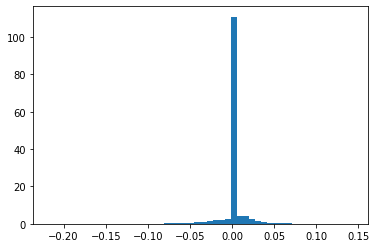

In [234]:
#Plot histogram of residuals.
plt.hist(rresiduals, bins=50, density=True)

print("Mean: ", np.mean(rresiduals))
print("Variance: ", np.var(rresiduals))


## RF Model to predict Ngal

In [167]:
#Make features and label arrays
features = ['halo_mass', 'v_vir','z_halo', 'v_disp']
label = ['Ngal']

X = data_set[features].values
y = np.ravel(data_set[label].values)

In [169]:
ntest_X = test_set[features].values
ntest_y = np.ravel(test_set[label].values)

In [168]:
#Split data into test and train sets
ntrain_X, nval_X, ntrain_y, nval_y =  train_test_split(X,y)

In [170]:
#Train Random Forest Model
nhalo_RF_model = RandomForestRegressor(n_estimators=100, max_depth=35, verbose=True)
nhalo_RF_model.fit(ntrain_X, ntrain_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.8min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=True, warm_start=False)

In [171]:
ntest_preds = nhalo_RF_model.predict(ntest_X)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.0s finished


In [172]:
# Print root mean squared error
from sklearn.metrics import mean_squared_error
print('RMSE Ngal: ', np.sqrt(mean_squared_error(ntest_y, ntest_preds)))
print('Mean Absolute Fractional Error for Ngal: ', np.mean(abs(ntest_preds-ntest_y)/ntest_y))
print('Training Set size: ', len(ntrain_y))
print('Test Set size: ', len(ntest_preds))

RMSE Ngal:  0.8288034967830451
Mean Absolute Fractional Error for Ngal:  0.047084091144401145
Training Set size:  412060
Test Set size:  49981


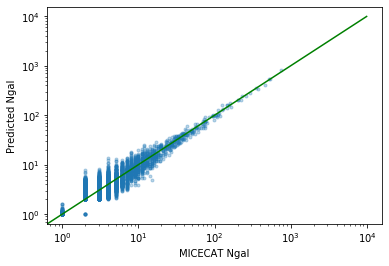

In [173]:
#Plot actual Ngal vs. predicted Ngal.
plt.plot(ntest_y, ntest_preds, '.', alpha=0.3)
plt.ylabel('Predicted Ngal')
plt.xlabel('MICECAT Ngal')
plt.xscale('log')
plt.yscale('log')
line_x, line_y = np.arange(0,10**4,100), np.arange(0,10**4,100)
plt.plot(line_x,line_y,'g-')
plt.show()

Text(0.5, 1.0, 'Ngal distributions for MICECAT and model prediction')

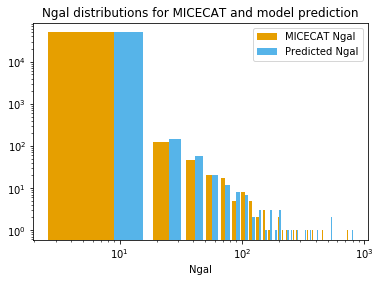

In [174]:
#Plot distributions of true Ngal and predicted Ngal

x1 = list(ntest_y)
x2 = list(ntest_preds.flatten())
# Assign colors for each group and the names
colors = ['#E69F00', '#56B4E9']
names = ['MICECAT Ngal', 'Predicted Ngal']

plt.hist([x1,x2], bins = 50, color=colors, label=names)
plt.yscale('log')
plt.xscale('log')

# Plot formatting
plt.legend()
plt.xlabel('Ngal')
#plt.ylabel('Normalized data')
plt.title('Ngal distributions for MICECAT and model prediction')

In [30]:
#Feature selection
nfeature_importances = pd.DataFrame(nhalo_RF_model.feature_importances_,
                                   index = data_set[features].columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(nfeature_importances)


           importance
v_disp       0.894213
z_halo       0.071868
halo_mass    0.021713
v_vir        0.012206


(-20, 20)

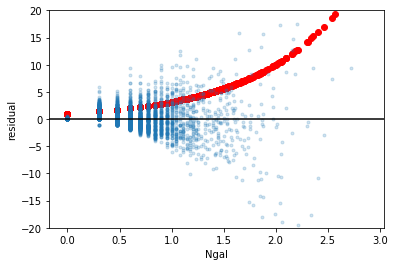

In [271]:
#Determine residuals and error.
poiss_err = np.sqrt(ntest_y)

nresiduals=ntest_preds-ntest_y
nerrors=nresiduals/ntest_y
plt.plot(np.log10(ntest_y), nresiduals, '.', alpha=0.2)
plt.scatter(np.log10(ntest_y), poiss_err, c='r')
plt.axhline(y=0, c='k')
plt.xlabel('Ngal')
plt.ylabel('residual')
plt.ylim(-20,20)
#plt.xscale('log')

Text(0.5, 0, 'Ngal')

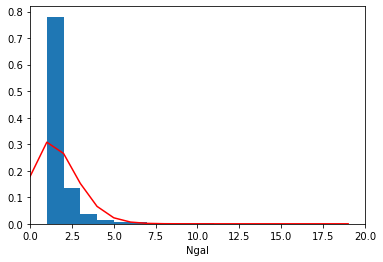

In [184]:
#Plot histogram of Ngal in test set.
plt.hist(ntest_y, bins=100, range=(0,100), density=True)

x = np.arange(0,20)
plt.plot(x, poisson(np.mean(ntest_y)).pmf(x), 'r-')
plt.xlim(0,20)
plt.xlabel('Ngal')

Mean:  0.05208043156367253
Variance:  0.6842028649279446


Text(0.5, 0, 'Ngal residuals')

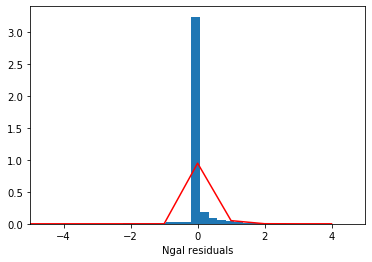

In [185]:
#Plot histogram of residuals.
plt.hist(nresiduals, bins=400, density=True)

print("Mean: ", np.mean(nresiduals))
print("Variance: ", np.var(nresiduals))

x = np.arange(-5,5)
plt.plot(x, poisson(np.mean(nresiduals)).pmf(x), 'r-')
plt.xlim(-5,5)
plt.xlabel('Ngal residuals')

Mean:  0.1752050162399945
Variance:  0.6562184385641463


Text(0.5, 0, 'Ngal residuals')

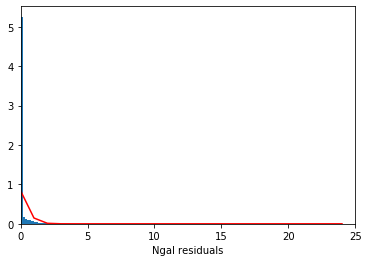

In [183]:
#Plot histogram of residuals.
plt.hist(abs(nresiduals), bins=400, density=True)

print("Mean: ", np.mean(abs(nresiduals)))
print("Variance: ", np.var(abs(nresiduals)))

x = np.arange(0,25)
plt.plot(x, poisson(np.mean(abs(nresiduals))).pmf(x), 'r-')
plt.xlim(0,25)
plt.xlabel('Ngal residuals')

Mean:  0.05208043156367253
Variance:  0.6842028649279446


Text(0.5, 1.0, 'Histogram of Ngal residuals with a normal fit')

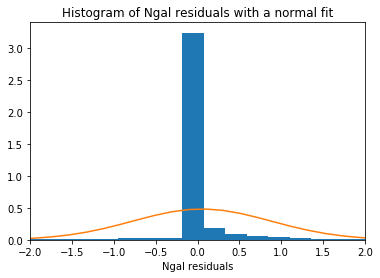

In [233]:

#Plot histogram of residuals.
plt.hist(nresiduals, bins=400, density=True)

print("Mean: ", np.mean(nresiduals))
print("Variance: ", np.var(nresiduals))

xt = plt.xticks()[0] 
#xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(-5, 5)

m, s = stats.norm.fit(nresiduals) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it
plt.xlim(-2,2)
plt.xlabel('Ngal residuals')
plt.title('Histogram of Ngal residuals with a normal fit')

Text(0.5, 1.0, 'Normal distribution on log residuals for Ngal')

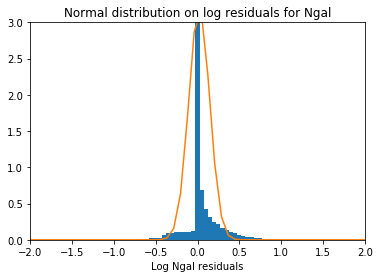

In [228]:
lognresiduals=np.log(ntest_preds)-np.log(ntest_y)

#Plot histogram of residuals.
plt.hist(lognresiduals, bins=50, density=True)

xt = plt.xticks()[0] 
#xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(-2, 2)

m, s = stats.norm.fit(lognresiduals) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="LogNorm") # plot it
plt.xlim(-2,2)
plt.ylim(0,3)
plt.xlabel('Log Ngal residuals')
plt.title('Normal distribution on log residuals for Ngal')

## Model to predict central galaxy magnitude

In [186]:
#Make features and label arrays
features = ['halo_mass','z_halo', 'v_disp', 'v_vir']
label = ['mag_central']

X = data_set[features].values
y = np.ravel(data_set[label].values)

In [187]:
#Split data into test and train sets
cmtrain_X, cmval_X, cmtrain_y, cmval_y =  train_test_split(X,y)

In [188]:
#Make test set arrays for features and targets.
cmtest_X = test_set[features].values
cmtest_y = np.ravel(test_set[label].values)

In [189]:
#Train Random Forest Model
cmhalo_RF_model = RandomForestRegressor(n_estimators=100, max_depth=35, verbose=True)
cmhalo_RF_model.fit(cmtrain_X, cmtrain_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.8min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=True, warm_start=False)

In [190]:
cmtest_preds = cmhalo_RF_model.predict(cmtest_X)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.9s finished


In [191]:
# Print root mean squared error
from sklearn.metrics import mean_squared_error
print('RMSE for central galaxy magnitude: ', np.sqrt(mean_squared_error(cmtest_y, cmtest_preds)))
print('Training Set size: ', len(cmtrain_y))
print('Test Set size: ', len(cmtest_preds))

RMSE for central galaxy magnitude:  0.04472234635182634
Training Set size:  412060
Test Set size:  49981


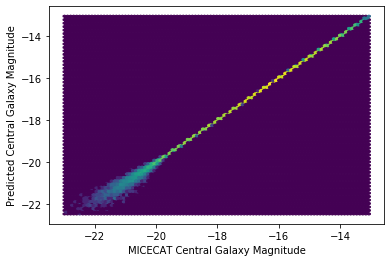

In [192]:
#Plot actual Ngal vs. predicted Ngal.
plt.hexbin(cmtest_y, cmtest_preds, bins='log')
plt.ylabel('Predicted Central Galaxy Magnitude')
plt.xlabel('MICECAT Central Galaxy Magnitude')
#plt.xscale('log')
#plt.yscale('log')
line_x, line_y = np.arange(-23,-14,1), np.arange(-23,-14,1)
#plt.plot(line_x,line_y,'r--')
plt.show()

In [258]:
print(cmtest_y[1])

-16.16417591077691


In [260]:
x = pd.DataFrame(cmtest_y, columns=['actual_mag'])
x['predicted_mag'] = cmtest_preds
x[x['actual_mag']<=-20].corr()

,actual_mag,predicted_mag
actual_mag,1.000000,0.940121
predicted_mag,0.940121,1.000000


Text(0.5, 1.0, 'Magnitude distributions for MICECAT and model prediction')

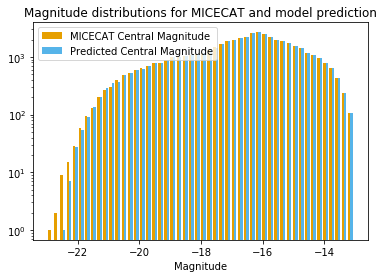

In [193]:
#Plot distributions of true Ngal and predicted Ngal

x1 = list(cmtest_y)
x2 = list(cmtest_preds.flatten())
# Assign colors for each group and the names
colors = ['#E69F00', '#56B4E9']
names = ['MICECAT Central Magnitude', 'Predicted Central Magnitude']

plt.hist([x1,x2], bins = 50, color=colors, label=names)
plt.yscale('log')
#plt.xscale('log')

# Plot formatting
plt.legend()
plt.xlabel('Magnitude')
#plt.ylabel('Normalized data')
plt.title('Magnitude distributions for MICECAT and model prediction')

In [194]:
#Feature selection
cmfeature_importances = pd.DataFrame(cmhalo_RF_model.feature_importances_,
                                   index = data_set[features].columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(cmfeature_importances)



           importance
halo_mass    0.971767
v_vir        0.021224
z_halo       0.004428
v_disp       0.002582


Text(0, 0.5, 'residual')

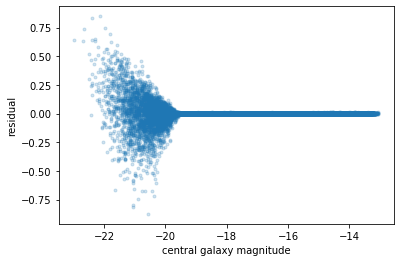

In [195]:
#Determine residuals and error.
cmresiduals=cmtest_preds-cmtest_y
cmerrors=cmresiduals/cmtest_y
plt.plot(cmtest_y, cmresiduals, '.', alpha=0.2)
plt.xlabel('central galaxy magnitude')
plt.ylabel('residual')

Text(0.5, 1.0, 'Histogram of Central Galaxy Magnitudes with a normal distribution fit')

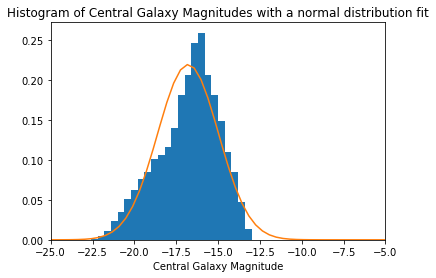

In [215]:
#Plot histogram of Central Galaxy Magnitude in test set.
plt.hist(cmtest_y, bins=50, range=(-25,-5), density=True)

xt = plt.xticks()[0] 
#xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(-25, -5)

m, s = stats.norm.fit(cmtest_y) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it
plt.xlim(-25,-5)
plt.xlabel('Central Galaxy Magnitude')
plt.title('Histogram of Central Galaxy Magnitudes with a normal distribution fit')

#### Looks like maybe there are two different distributions - I wonder if this corresponds to single galaxy halos and multiple galaxy halos?

Mean:  0.00033991417341625897
Variance:  0.001999972721567426


Text(0.5, 1.0, 'Residuals for Central Galaxy Magnitude wiht a normal fit')

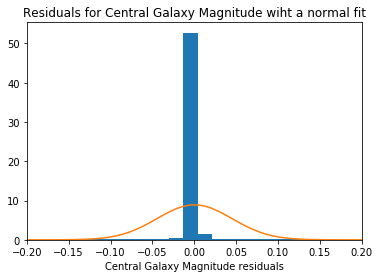

In [216]:
#Plot histogram of residuals.
plt.hist(cmresiduals, bins=100, density=True)

print("Mean: ", np.mean(cmresiduals))
print("Variance: ", np.var(cmresiduals))

xt = plt.xticks()[0] 
#xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(-0.2, 0.2)

m, s = stats.norm.fit(cmresiduals) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it
plt.xlim(-0.2,0.2)
plt.xlabel('Central Galaxy Magnitude residuals')
plt.title('Residuals for Central Galaxy Magnitude wiht a normal fit')

[-1.29375723e-04 -1.52485085e-04 -2.86129139e-05 ... -6.02246033e-05
 -2.27249918e-04 -6.71770700e-05]


Text(0.5, 0, 'Central Galaxy Magnitude residuals')

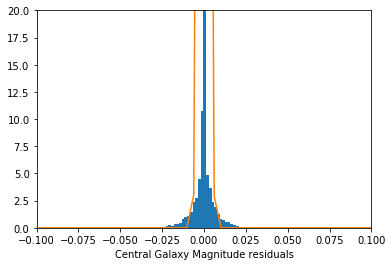

In [222]:
logcmresiduals=np.log(abs(cmtest_preds))-np.log(abs(cmtest_y))
print(logcmresiduals)

#Plot histogram of residuals.
plt.hist(logcmresiduals, bins=50, density=True)

xt = plt.xticks()[0] 
#xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(-0.1, 0.1)

m, s = stats.norm.fit(logcmresiduals) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="LogNorm") # plot it
plt.xlim(-0.1,0.1)
plt.ylim(0,20)
plt.xlabel('Central Galaxy Magnitude residuals')

## Model to predict magnitude gap

In [42]:
#Make features and label arrays
features = ['halo_mass','z_halo', 'v_disp', 'v_vir']
label = ['mag_gap']

X = data_set[features].values
y = np.ravel(data_set[label].values)

In [43]:
#Split data into test and train sets
mgtrain_X, mgval_X, mgtrain_y, mgval_y =  train_test_split(X,y)

In [49]:
#Train Random Forest Model
mghalo_RF_model = RandomForestRegressor(n_estimators=100, max_depth=35, verbose=True)
mghalo_RF_model.fit(mgtrain_X, mgtrain_y)
mgval_preds = mghalo_RF_model.predict(mgval_X)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 71.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.4s finished


In [50]:
# Print root mean squared error
from sklearn.metrics import mean_squared_error
print('RMSE for magnitude gap: ', np.sqrt(mean_squared_error(mgval_y, mgval_preds)))
print('Training Set size: ', len(mgtrain_y))
print('Test Set size: ', len(mgval_preds))

RMSE for magnitude gap:  0.9900826394715065
Training Set size:  412181
Test Set size:  137394


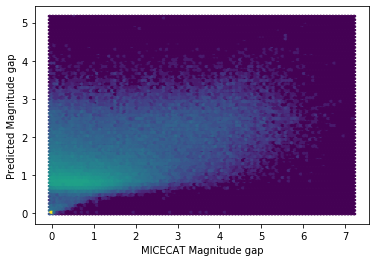

In [51]:
#Plot actual Ngal vs. predicted Ngal.
plt.hexbin(mgval_y, mgval_preds, bins='log')
plt.ylabel('Predicted Magnitude gap')
plt.xlabel('MICECAT Magnitude gap')
#plt.xscale('log')
#plt.yscale('log')
line_x, line_y = np.arange(-23,-14,1), np.arange(-23,-14,1)
#plt.plot(line_x,line_y,'r--')
plt.show()

Text(0.5, 1.0, 'Magnitude gap distributions for MICECAT and model prediction')

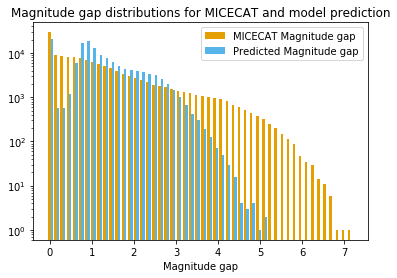

In [52]:
#Plot distributions of true Ngal and predicted Ngal

x1 = list(mgval_y)
x2 = list(mgval_preds.flatten())
# Assign colors for each group and the names
colors = ['#E69F00', '#56B4E9']
names = ['MICECAT Magnitude gap', 'Predicted Magnitude gap']

plt.hist([x1,x2], bins = 50, color=colors, label=names)
plt.yscale('log')
#plt.xscale('log')

# Plot formatting
plt.legend()
plt.xlabel('Magnitude gap')
#plt.ylabel('Normalized data')
plt.title('Magnitude gap distributions for MICECAT and model prediction')

In [54]:
#Feature selection
mgfeature_importances = pd.DataFrame(mghalo_RF_model.feature_importances_,
                                   index = data_set[features].columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(mgfeature_importances)

           importance
v_disp       0.374032
halo_mass    0.309938
z_halo       0.205958
v_vir        0.110072


/Users/amandawhaley/anaconda3/envs/MLGalaxyClusters/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/amandawhaley/anaconda3/envs/MLGalaxyClusters/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'residual')

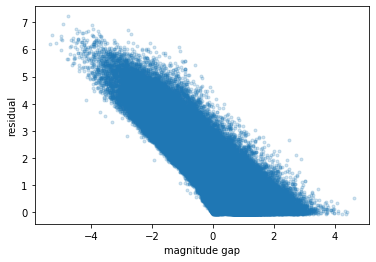

In [55]:
#Determine residuals and error.
mgresiduals=mgval_preds-mgval_y
mgerrors=mgresiduals/mgval_y
plt.plot(mgresiduals, mgval_y, '.', alpha=0.2)
plt.xlabel('magnitude gap')
plt.ylabel('residual')

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 400, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [ ]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
pprint(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=True, random_state=42, n_jobs = -1)

#Make features and label arrays
features = ['halo_mass','z_halo', 'v_disp']
label = ['Ngal']

X = data_set[features].values
y = np.ravel(data_set[label].values)
#Split data into test and train sets
train_X, val_X, train_y, val_y =  train_test_split(X,y)

# Fit the random search model
rf_random.fit(train_X, train_y)

#Print best paramaters.
print(rf_random.best_params_)

In [ ]:
pd.DataFrame.from_dict(rf_random.cv_results_)

In [ ]:
best_random = rf_random.best_estimator_

In [ ]:
best_random.fit(train_X, train_y)
best_preds = best_random.predict(val_X)

In [ ]:
print('RMSE Ngal: ', np.sqrt(mean_squared_error(val_y, best_preds)))
print('Mean Absolute Fractional Error for Ngal: ', np.mean(abs(best_preds-val_y)/val_y))

In [ ]:
#Plot actual Ngal vs. predicted Ngal.
plt.plot(val_y, best_preds, '.', alpha=0.3)
plt.ylabel('Predicted Ngal')
plt.xlabel('MICECAT Ngal')
plt.xscale('log')
plt.yscale('log')
line_x, line_y = np.arange(0,10**4,100), np.arange(0,10**4,100)
plt.plot(line_x,line_y,'g-')
plt.show()

In [ ]:
#Feature selection
feature_importances = pd.DataFrame(best_random.feature_importances_,
                                   index = data_set[features].columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

